# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# посмотрим на выборку
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head(7)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24


In [ ]:
# информация о DataFrame
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


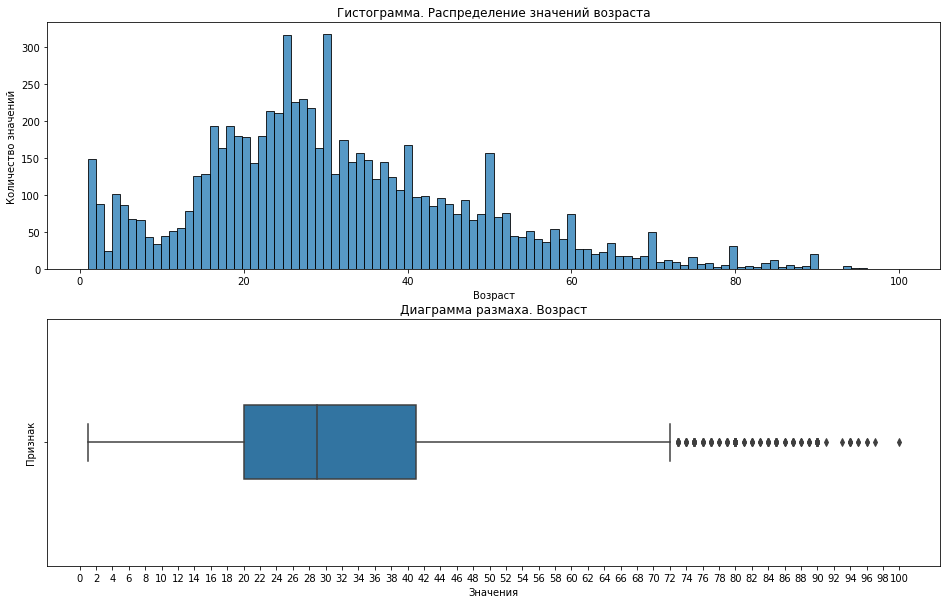

In [ ]:
# построим гистограмму распределения возраста в выборке, а также диаграмму размаха
fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(2, 1, 1)
sns.histplot(x=labels['real_age'], bins=100)
plt.title(f'Гистограмма. Распределение значений возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество значений')

ax = fig.add_subplot(2, 1, 2)
sns.boxplot(x=labels['real_age'], width=.3)
plt.title(f'Диаграмма размаха. Возраст')
plt.xlabel('Значения')
plt.ylabel('Признак')
plt.xticks(np.arange(0, 101, 2))

pass

In [ ]:
# загрузим изображения
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


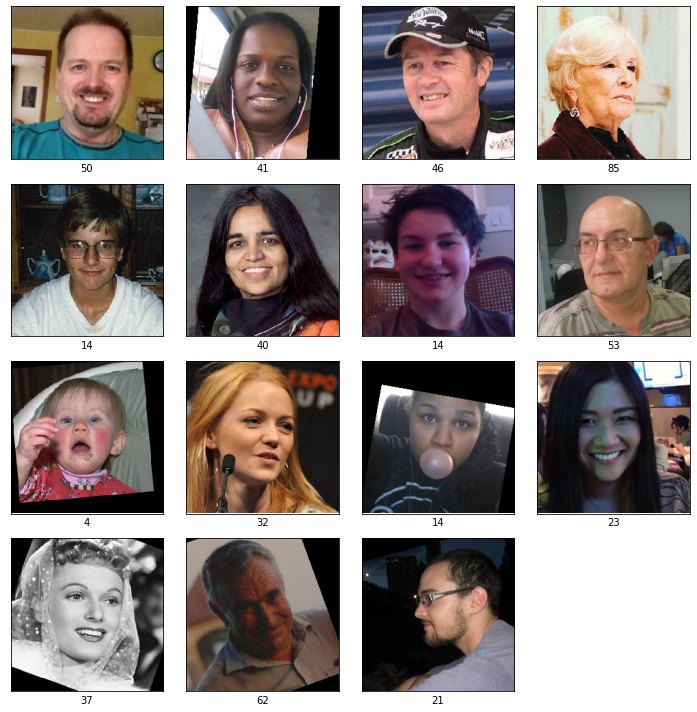

In [ ]:
# выведем 15 фотографий с указанием возраста на экран
features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel(target[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [ ]:
# посмотрим размерность тензора признаков
features.shape

(32, 224, 224, 3)

### Выводы

Количество фотографий не очень большое: нужно следить, чтобы нейросеть не переобучилась.<br><br>
Чаще всего встречаются фотографии людей в возрасте 15-35 лет.<br>
В целом, чем старше, тем меньше фотографий.<br><br>
Все, что выше 72 лет, диаграмма размаха считает выбросами. Но удалять данные не будем.
Особенности фотографий:<br>
- не на всех фотографиях лица показаны полностью;
- некоторые фото повернуты;
- некоторые фото сжаты;
- есть фото с 2 лицами;
- есть фотографии качественные и 'пиксельные';
- есть фото, где лица сложно разобрать;
- снимки цветные и черно-белые;
- Билл Гейтс встречается на картинках > 1 раза.

## Обучение модели

Код обучения модели и её результат вывода на экран представлены ниже.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=False,
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0
        )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name', # имена изображений
        y_col='real_age', # метки изображений
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw', # используется, если целевой признак является integer
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
        )

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345
        )

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet')

    # замораживаем ResNet50 без верхушки
    # backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
              metrics=['mae'])

    model.summary()

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=9,
               steps_per_epoch=None, validation_steps=None):

    train_datagen_flow = train_data
    test_datagen_flow = test_data
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________

Train for 178 steps, validate for 60 steps
Epoch 1/9
178/178 - 82s - loss: 276.1556 - mae: 11.8189 - val_loss: 744.2519 - val_mae: 22.3368
Epoch 2/9
178/178 - 43s - loss: 78.4037 - mae: 6.6454 - val_loss: 505.8076 - val_mae: 17.3139
Epoch 3/9
178/178 - 43s - loss: 50.4692 - mae: 5.4425 - val_loss: 298.1573 - val_mae: 12.5545
Epoch 4/9
178/178 - 43s - loss: 36.1880 - mae: 4.5762 - val_loss: 129.3101 - val_mae: 8.3464
Epoch 5/9
178/178 - 43s - loss: 27.1532 - mae: 3.9955 - val_loss: 75.0222 - val_mae: 6.5643
Epoch 6/9
178/178 - 43s - loss: 21.9718 - mae: 3.5528 - val_loss: 81.5039 - val_mae: 6.8772
Epoch 7/9
178/178 - 42s - loss: 17.1945 - mae: 3.1685 - val_loss: 67.8152 - val_mae: 6.0869
Epoch 8/9
178/178 - 43s - loss: 14.6112 - mae: 2.9342 - val_loss: 72.9169 - val_mae: 6.2650
Epoch 9/9
178/178 - 42s - loss: 11.9547 - mae: 2.6500 - val_loss: 63.3871 - val_mae: 5.8041

60/60 - 10s - loss: 63.3871 - mae: 5.8041

```

## Анализ обученной модели

В данном проекте с целью определения возраста покупателей в качестве основной (backbone) была использована нейрость ReNet50 с весами датасета ImageNet.<br><br>
Использован 1 полносвязный слой (большее количество слоев в (т.ч. BatchNormalization) ухудшало качество модели). <br>В модели не использовалось замораживание ResNet50 без верхушки (т.к. это давало худший результат). В качестве целевой метрики использована MAE.<br><br>
За 9 эпох и c применением алгоритма Adam удалось достичь метрики MAE на тестовой выборке со значением 6.591. С большой долей вероятности тренировочную и тестовую метрики можно улучшить, увеличивая количество эпох, а также проводя дополнительные аугментации исходных изображений.

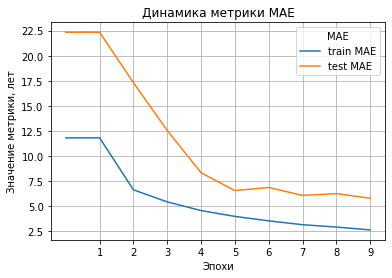

In [ ]:
# визуализируем динамику метрики MAE
train_mae = [11.8189, 11.8189, 6.6454, 5.4425, 4.5762, 3.99557, 3.5528, 3.1685, 2.9342, 2.6500]
val_mae = [22.3368, 22.3368, 17.3139, 12.5545, 8.3464, 6.5643, 6.8772, 6.0869, 6.2650, 5.8041]
sns.lineplot(data=train_mae)
sns.lineplot(data=val_mae)
plt.title(f'Динамика метрики MAE')
plt.xlabel('Эпохи')
plt.ylabel('Значение метрики, лет')
plt.xticks(np.arange(1, 10, 1))
plt.grid()
plt.legend(title='MAE', loc='upper right', labels=['train MAE', 'test MAE'])
pass

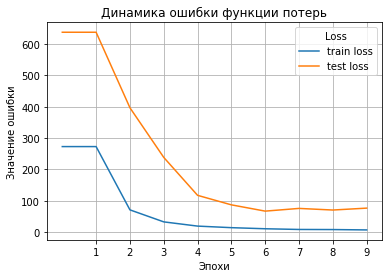

In [ ]:
# визуализируем динамику ошибки функции потерь
train_loss = [276.1556, 276.1556, 78.4037, 50.4692, 36.188, 27.1532, 21.9718., 17.1945, 14.6112, 11.9547]
val_loss = [744.2519, 744.2519, 505.8076, 298.1573, 129.3101, 75.0222, 81.5039, 67.8152, 72.9169, 63.3871]
sns.lineplot(data=train_loss)
sns.lineplot(data=val_loss)
plt.title(f'Динамика ошибки функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Значение ошибки')
plt.xticks(np.arange(1, 10, 1))
plt.grid()
plt.legend(title='Loss', loc='upper right', labels=['train loss', 'test loss'])
pass